# Modeling and Simulation of Parallel and Distributed Systems (MSPDS 2016)

In [1]:
import pandas as pd
pd.options.display.precision = 2
import numpy as np
from IPython.display import display
## Matplotlib configuration
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')  # R style
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2,
                            'axes.xmargin': 0.1,
                            'axes.ymargin': 0.1})

from lib import DataFrameBuilder, Outlier, Humanizer, Plotter


plotter = Plotter()

## Conventions
# Cell variables start with "t_"

## Wikipedia Application

### Total time

#### Target

,GiB,workers,executions,outliers,available
0,45,4,30,2,28
1,45,8,30,1,29
2,45,16,30,2,28
3,45,32,30,2,28
4,45,64,30,1,29


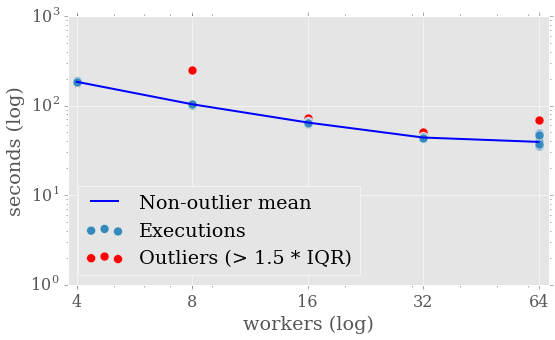

Total target application duration using the complete dataset (45 GB).


In [2]:
df = DataFrameBuilder.get_target_df()
df['outlier'] = Outlier.is_outlier(df)
overview = Outlier.get_overview(df)
display(Humanizer.humanize(overview, size=Humanizer.SIZE_GIB))
plotter.plot_outliers(df, (3.8, 68), (1, 1000), logx=True, logy=True, loc='lower left')
print('Total target application duration using the complete dataset (45 GB).')

#### Profiling

##### Weak scaling

,GiB,workers,executions,outliers,available
0,1,1,30,2,28
1,2,2,30,1,29
2,4,4,30,1,29
3,8,8,30,0,30
4,16,16,30,2,28
5,32,32,30,0,30
6,45,45,30,2,28


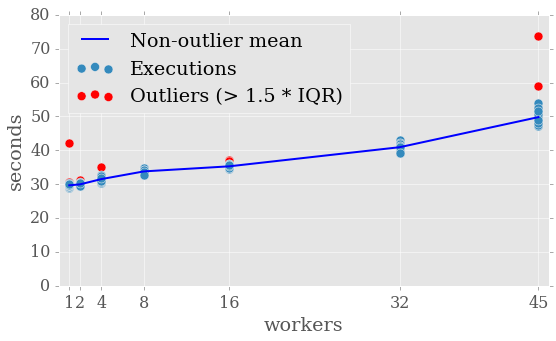

Total duration of the weak-scaling profiling experiment using the same amount of data (GB) as the amount of workers.


In [3]:
df = DataFrameBuilder.get_weak_scaling_df()
df['outlier'] = Outlier.is_outlier(df)
overview = Outlier.get_overview(df)
display(Humanizer.humanize(overview, size=Humanizer.SIZE_GIB))
plotter.plot_outliers(df, (0, 46), loc='upper left')
print('Total duration of the weak-scaling profiling experiment using the same'
      ' amount of data (GB) as the amount of workers.')

#####  Strong scaling 1

,MiB,workers,executions,outliers,available
0,1024,1,10,1,9
1,1024,2,10,2,8
2,1024,4,10,0,10


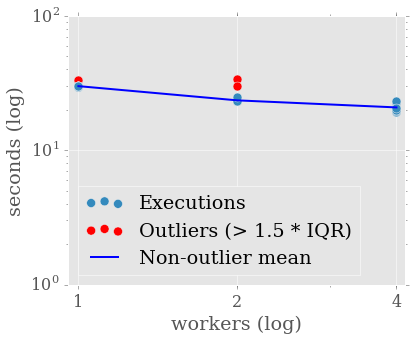

Total duration of profiling executions with 1-GB input using 1, 2 and 4 workers.


In [4]:
df = DataFrameBuilder.get_strong_scaling_df(1)
df['outlier'] = Outlier.is_outlier(df)
overview = Outlier.get_overview(df)
display(Humanizer.humanize(overview, size=Humanizer.SIZE_MIB))
plotter.plot_outliers(df, (0.956, 4.16), (1, 100), figsize=(6, 5), logx=True, logy=True)
print('Total duration of profiling executions with 1-GB input using 1, 2 and 4 workers.')

##### One VM

,MiB,workers,executions,outliers,available
0,128,1,10,0,10
1,256,1,10,0,10
2,512,1,10,0,10
3,1024,1,10,0,10


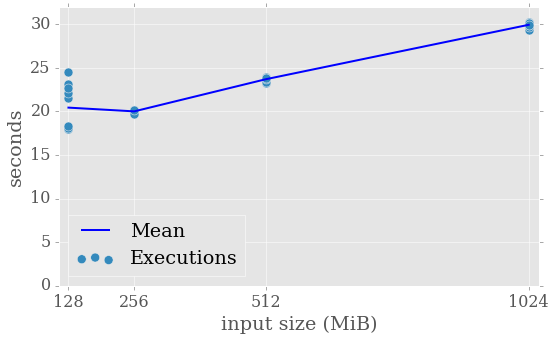

Total duration in one VM with different input sizes.


In [9]:
df = DataFrameBuilder.get_one_vm_df()
df['outlier'] = Outlier.is_outlier(df)
overview = Outlier.get_overview(df)
display(Humanizer.humanize(overview, size=Humanizer.SIZE_MIB))
plotter.plot_outliers(df, (109, 1044), loc='lower left')
print('Total duration in one VM with different input sizes.')

##### Strong scaling 2

,GiB,workers,executions,outliers,available
0,1,1,10,1,9
1,1,2,10,2,8
2,1,3,10,1,9


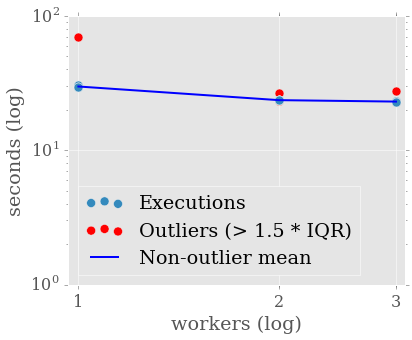

Total duration of profiling executions with 1-GB input using 1, 2 and 3 workers.


In [7]:
df = DataFrameBuilder.get_strong_scaling_df(2)
df['outlier'] = Outlier.is_outlier(df)
overview = Outlier.get_overview(df)
display(Humanizer.humanize(overview, size=Humanizer.SIZE_GIB))
plotter.plot_outliers(df, (0.965, 3.1), (1, 100), figsize=(6, 5), logx=True, logy=True)
print('Total duration of profiling executions with 1-GB input using 1, 2 and 3 workers.')

### Machine Learning

In [65]:
profiling = display_experiment_overview1vm('data/wikipedia/profiling/one_vm/')

,MiB,executions,outliers,available
0,128,10,False,10
1,256,10,False,10
2,512,10,False,10
3,1024,10,False,10


In [63]:
profiling.tail(3)

,input,ms,outlier
37,1073741798,29939,False
38,1073741798,30120,False
39,1073741798,29957,False


In [66]:
training = profiling[~profiling.outlier].drop('outlier', axis=1)
training.input /= 1024**2
training.tail(3)

,input,ms
37,1024.0,29939
38,1024.0,30120
39,1024.0,29957


,input,ms
24,536816741,23739
3,134217465,17986
16,268425644,20149


In [ ]:
from sklearn import linear_model

def eval_model(model, features, y, revert=None):
    display(features.sample(3))
    print('Training features')
    model.fit(features, y)
    
    # Predictions ordered by 1st col of 'features'
    to_predict = features.drop_duplicates().sort_values(features.columns[0])
    prediction = model.predict(to_predict)
    if revert:
        prediction = revert(prediction)

    # Plot total durations by number of workers.
    # From milliseconds to seconds
    df_plot = pd.DataFrame({'workers': dfp.workers, 'seconds': dfp.ms/1000})
    # Plot mean (non-outliers)
    means = df_plot.groupby('workers').mean().rename(columns={'seconds': 'Mean'})
    ax = means.plot(style='bo-', ms=8, figsize=(8, 5))
    # Plot predictions
    ax.plot([1, 2, 4], prediction/1000, 'rs--', label='Prediction', ms=8)

    # Plot settings
    ax.set_xticks(df.workers.unique())
    ax.set_xlim(0.9, 4.1)
    ax.set_ylim(0, None)
    ax.set_ylabel('seconds')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print('Mean durations from the experiment and model predictions.')
    
    return model


eval_model(linear_model.LinearRegression(), dfp[['workers', 'bytes']], dfp['ms'])

In [ ]:
# Using features' log

t_features = df[['workers', 'bytes']].apply(np.log2)
t_y = np.log2(df['ms'])
eval_model(linear_model.LinearRegression(), t_features, t_y, lambda x: 2**x)

In [ ]:
t_features = df[['workers', 'bytes']].apply(np.log2)

t_features['w2'] = t_features.workers**2
#t_features['b2'] = t_features.bytes**2
#t_features['wb'] = t_features.workers * t_features.bytes
t_y = np.log2(df['ms'])
eval_model(linear_model.LinearRegression(), t_features, t_y, lambda x: 2**x)

In [ ]:
t_features = pd.DataFrame()
t_features['workers'] = df.workers
t_features['GB'] = df.bytes/10**10
t_features['w2'] = t_features.workers**2
t_features['GB2'] = t_features.GB**2
t_features['wb'] = t_features.workers * t_features.GB
t_y = df['ms']
t_model = eval_model(linear_model.LinearRegression(), t_features, t_y)
print('{:f} {:s}'.format(t_model.intercept_, str(t_model.coef_)))

%reset_selective -f t_
%who_ls

#### Target Experiment

In [ ]:
t_experiment = Experiment()
apps = t_experiment.parse